## References
https://www.medi-08-data-06.work/entry/regression_stan

In [2]:
import numpy as np
import numpy.random as rd
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation as ani
import matplotlib.cm as cm
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)

from tabulate import tabulate
from time import time

import pystan
from pystan import StanModel

### data

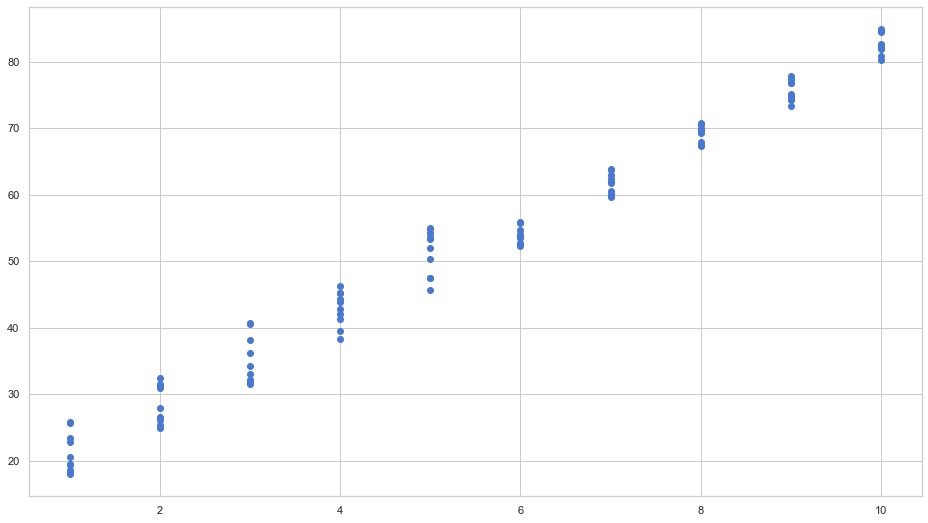

In [24]:
#Linear data
data = np.zeros([0,2])
for study_time in range(1,11):
    for p in range(0,10):
        if study_time<6:
            y = 10 + 7*study_time + 10*np.random.rand()
        else:
            y = 10 + 7*study_time + 5*np.random.rand()
        temp_data = np.array([study_time, y])
        data = np.vstack([data, temp_data])
plt.figure(figsize=(16,9), facecolor="white")
plt.scatter(data[:,0], data[:,1])
plt.show()